
## CAPSTONE PROJECT


**Name:Jennifer eias<br>
Class:4BSCDS<br>
RegNo:21112039**

**TOPIC:TRAFFIC PREDICTION**<br>
<br>
Traffic congestion is rising in cities around the world. Contributing factors include expanding urban populations, aging infrastructure, inefficient and uncoordinated traffic signal timing and a lack of real-time data.<br>
Traffic Prediction involves forecasting traffic conditions, such as the volume of vehicles and travel time, in a specific area or along a particular road. This task is important for optimizing transportation systems and reducing traffic congestion.


In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import datetime  
import tensorflow  
from statsmodels.tsa.stattools import adfuller  
from sklearn.preprocessing import MinMaxScaler  
from tensorflow import keras  
from keras import callbacks  
from tensorflow.keras import Sequential  
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional  
from tensorflow.keras.optimizers import SGD  
import math  
from sklearn.metrics import mean_squared_error  
import warnings  
warnings.filterwarnings("ignore")  

In [2]:
dataset = pd.read_csv("C:/Users/ADMIN/Documents/CU/sem4/ML/capstone project/traffic.csv")  
dataset.head()  

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
dataset["DateTime"]= pd.to_datetime(dataset["DateTime"])  
dataset = dataset.drop(["ID"], axis=1) #dropping IDs column  
dataset.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

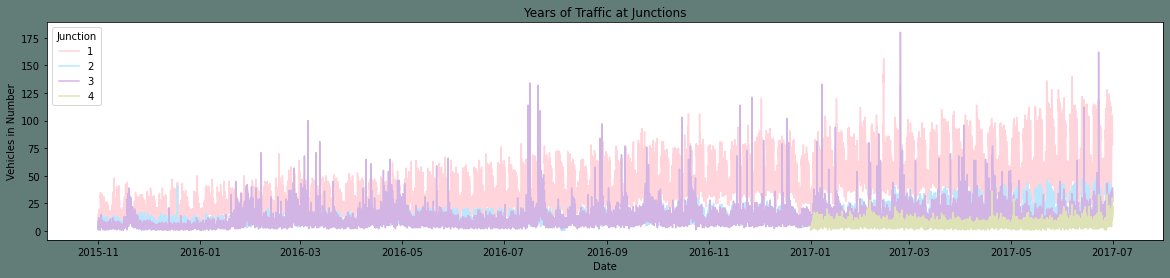

In [4]:
# dataframe to be used for EDA  
dataframe=dataset.copy()  
  
# Let's plot the Timeseries  
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]  
plt.figure(figsize=(20,4),facecolor="#627D78")  
Time_series=sns.lineplot(x=dataframe['DateTime'],y="Vehicles",data=dataframe, hue="Junction", palette=colors)  
Time_series.set_title("Years of Traffic at Junctions")  
Time_series.set_ylabel("Vehicles in Number")  
Time_series.set_xlabel("Date")  

In [5]:
# Exploring more features  
dataframe["Year"]= dataframe['DateTime'].dt.year  
dataframe["Month"]= dataframe['DateTime'].dt.month  
dataframe["Date_no"]= dataframe['DateTime'].dt.day  
dataframe["Hour"]= dataframe['DateTime'].dt.hour  
dataframe["Day"]= dataframe.DateTime.dt.strftime("%A")  
dataframe.head()  

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


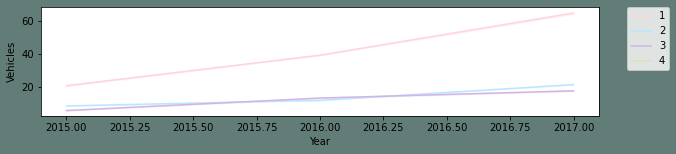

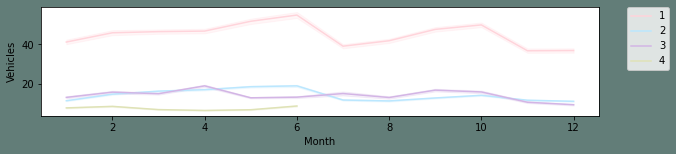

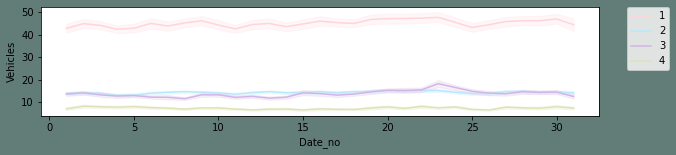

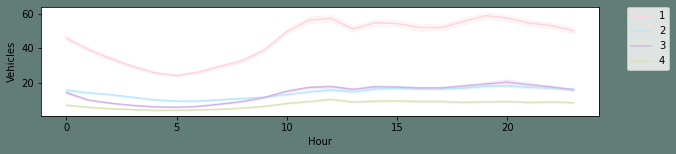

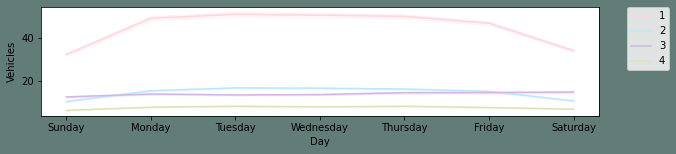

In [6]:
# Let's plot the Timeseries  
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]  
  
for i in new_features:  
    plt.figure(figsize=(10,2),facecolor="#627D78")  
    ax=sns.lineplot(x=dataframe[i],y="Vehicles",data=dataframe, hue="Junction", palette=colors )  
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  

Text(0.5, 0, 'Date')

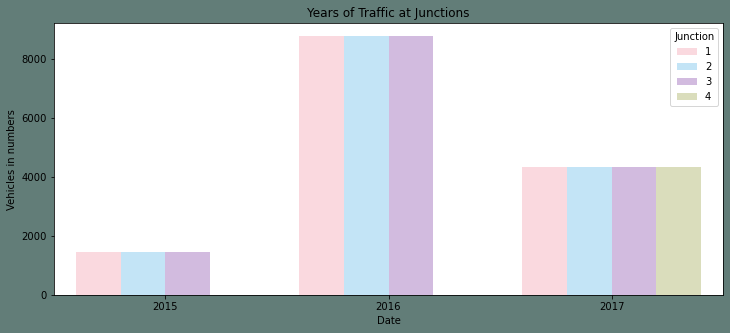

In [7]:
plt.figure(figsize=(12,5),facecolor="#627D78")  
count = sns.countplot(data=dataframe, x =dataframe["Year"], hue="Junction", palette=colors)  
count.set_title("Years of Traffic at Junctions")  
count.set_ylabel("Vehicles in numbers")  
count.set_xlabel("Date")  

<AxesSubplot:>

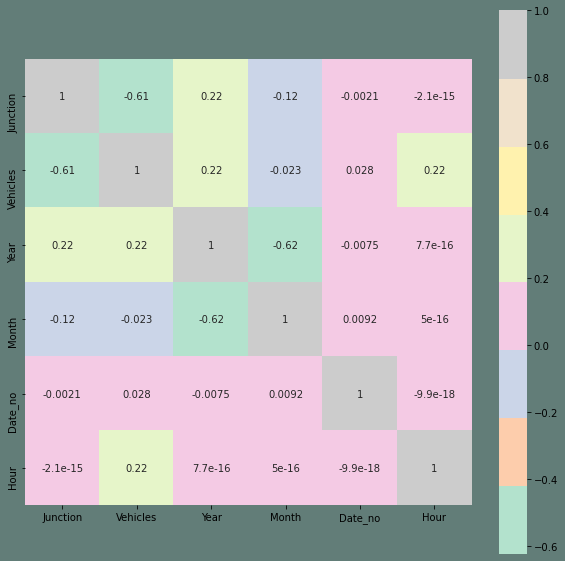

In [8]:
corrmat = dataframe.corr()  
plt.subplots(figsize=(10,10),facecolor="#627D78")  
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )  

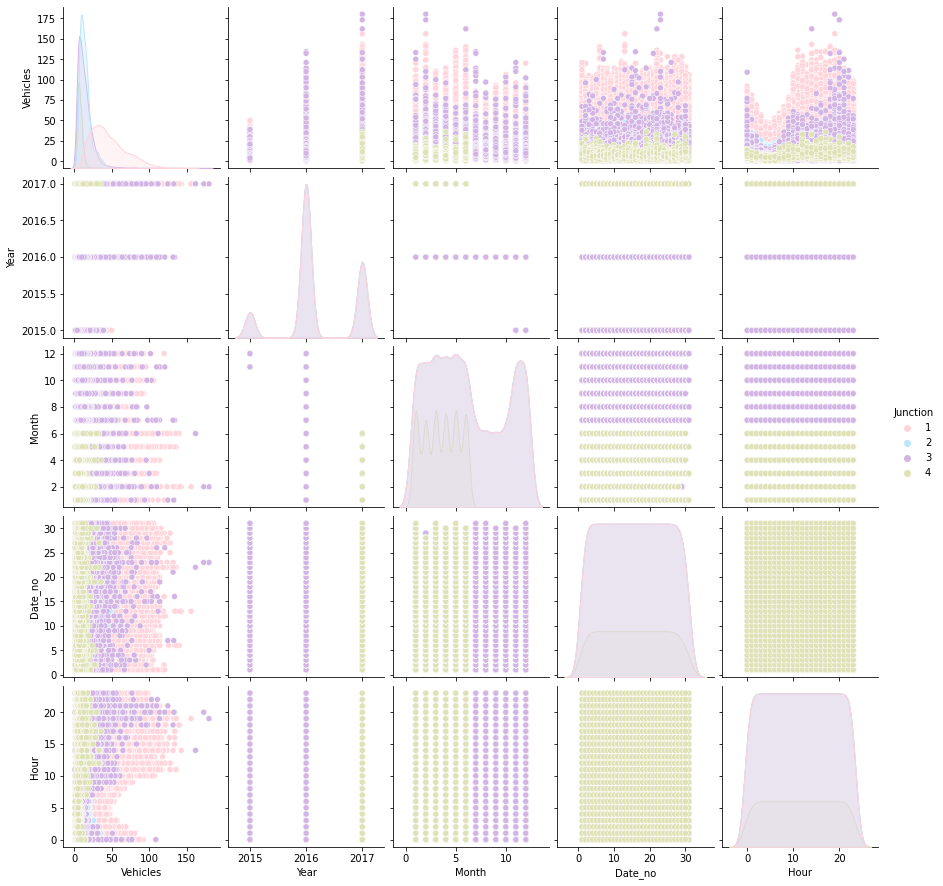

In [9]:
sns.pairplot(data=dataframe, hue= "Junction",palette=colors)  

In [10]:
# Pivoting dataset from junction  
dataframe_junction = dataset.pivot(columns="Junction", index="DateTime")  
dataframe_junction.describe()  

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

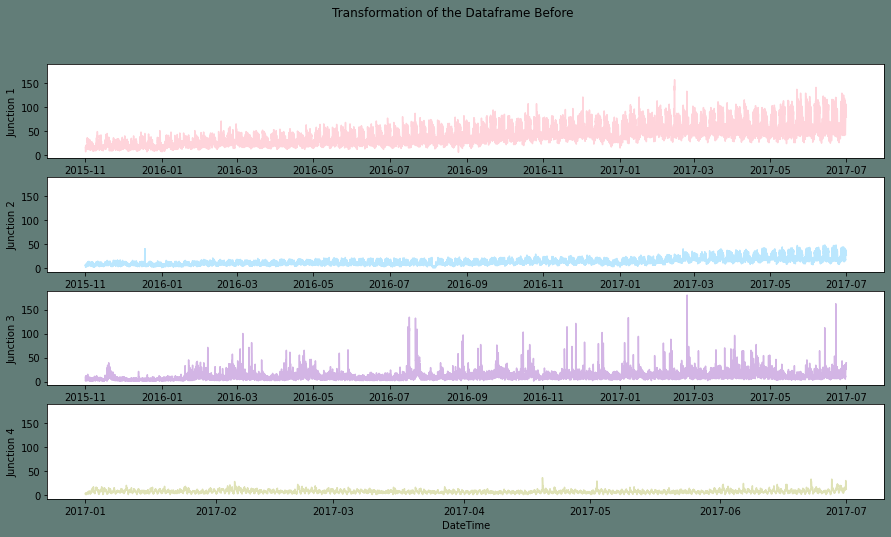

In [11]:
# Creating new dataframes  
dataframe_1 = dataframe_junction[[('Vehicles', 1)]]  
dataframe_2 = dataframe_junction[[('Vehicles', 2)]]  
dataframe_3 = dataframe_junction[[('Vehicles', 3)]]  
dataframe_4 = dataframe_junction[[('Vehicles', 4)]]  
dataframe_4 = dataframe_4.dropna() #For only a few months, Junction 4 has only had minimal data.  
  
# As DFS's data frame contains many indices, its index is lowering level one.  
list_dfs = [dataframe_1, dataframe_2, dataframe_3, dataframe_4]  
for i in list_dfs:  
    i.columns= i.columns.droplevel(level=1)    
  
# Creates comparison dataframe charts using this function  
def Sub_Plots4(dataframe_1, dataframe_2,dataframe_3,dataframe_4,title):  
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)  
    fig.suptitle(title)  
    #J1  
    pl_1=sns.lineplot(ax=axes[0],data=dataframe_1,color=colors[0])  
    #pl_1=plt.ylabel()  
    axes[0].set(ylabel ="Junction 1")  
    #J2  
    pl_2=sns.lineplot(ax=axes[1],data=dataframe_2,color=colors[1])  
    axes[1].set(ylabel ="Junction 2")  
    #J3  
    pl_3=sns.lineplot(ax=axes[2],data=dataframe_3,color=colors[2])  
    axes[2].set(ylabel ="Junction 3")  
    #J4  
    pl_4=sns.lineplot(ax=axes[3],data=dataframe_4,color=colors[3])  
    axes[3].set(ylabel ="Junction 4")  
     
     
# It is displayed to test for stationarity.  
Sub_Plots4(dataframe_1.Vehicles, dataframe_2.Vehicles,dataframe_3.Vehicles,dataframe_4.Vehicles,"Transformation of the Dataframe Before")  

In [12]:
# Normalize Function  
def Normalize(dataframe,column):  
    average = dataframe[column].mean()  
    stdev = dataframe[column].std()  
    df_normalized = (dataframe[column] - average) / stdev  
    df_normalized = df_normalized.to_frame()  
    return df_normalized, average, stdev  

In [13]:
# Differencing Function  
def Difference(dataframe,column, interval):  
    diff = []  
    for i in range(interval, len(dataframe)):  
        value = dataframe[column][i] - dataframe[column][i - interval]  
        diff.append(value)  
    return diff  

In [14]:
# In order to make the series stationary, normalize and differ  
dataframe_N1, avg_J1, std_J1 = Normalize(dataframe_1, "Vehicles")  
Diff_1 = Difference(dataframe_N1, column="Vehicles", interval=(24*7)) #taking a week's difference  
dataframe_N1 = dataframe_N1[24*7:]  
dataframe_N1.columns = ["Norm"]  
dataframe_N1["Diff"]= Diff_1  
  
dataframe_N2, avg_J2, std_J2 = Normalize(dataframe_2, "Vehicles")  
Diff_2 = Difference(dataframe_N2, column="Vehicles", interval=(24)) #taking a day's difference  
dataframe_N2 = dataframe_N2[24:]  
dataframe_N2.columns = ["Norm"]  
dataframe_N2["Diff"]= Diff_2  
  
dataframe_N3, avg_J3, std_J3 = Normalize(dataframe_3, "Vehicles")  
Diff_3 = Difference(dataframe_N3, column="Vehicles", interval=1) #taking an hour's difference  
dataframe_N3 = dataframe_N3[1:]  
dataframe_N3.columns = ["Norm"]  
dataframe_N3["Diff"]= Diff_3  
  
dataframe_N4, avg_J4, std_J4 = Normalize(dataframe_4, "Vehicles")  
Diff_4 = Difference(dataframe_N4, column="Vehicles", interval=1) #taking an hour's difference  
dataframe_N4 = dataframe_N4[1:]  
dataframe_N4.columns = ["Norm"]  
dataframe_N4["Diff"]= Diff_4  

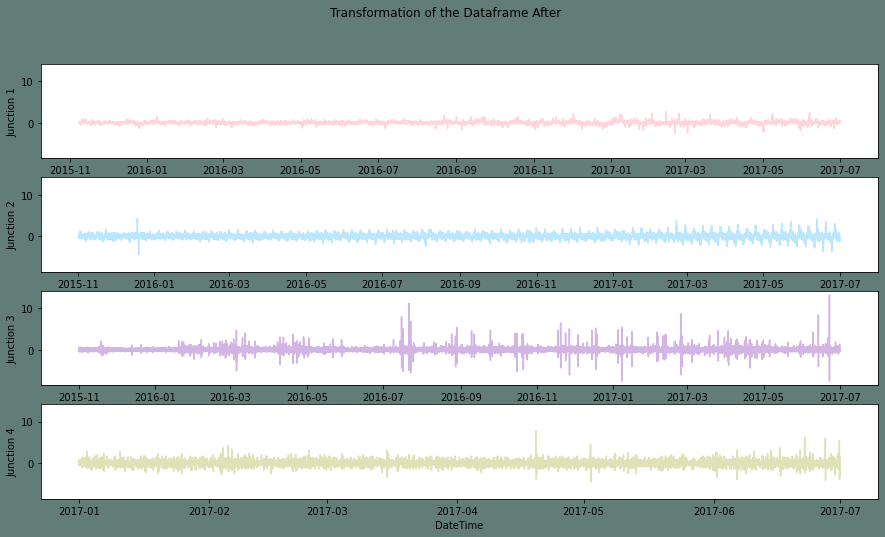

In [15]:
# plots  of transformed Dataframe
Sub_Plots4(dataframe_N1.Diff, dataframe_N2.Diff,dataframe_N3.Diff,dataframe_N4.Diff,"Transformation of the Dataframe After")  

In [16]:
# Stationary time series check Improved Dickey-Fuller test  
def Stationary_check(dataframe):  
    check = adfuller(dataframe.dropna())  
    print(f"ADF Statistic: {check[0]}")  
    print(f"p-value: {check[1]}")  
    print("Critical Values:")  
    for key, value in check[4].items():  
        print('\t%s: %.3f' % (key, value))  
    if check[0] > check[4]["1%"]:  
        print("Time Series is Non-Stationary")  
    else:  
        print("Time Series is Stationary")  
        
# examining the series' stationary state  
  
List_df_ND = [ dataframe_N1["Diff"], dataframe_N2["Diff"], dataframe_N3["Diff"], dataframe_N4["Diff"]]  
print("Checking the transformed series for stationarity:")  
for i in List_df_ND:  
    print("\n")  
    Stationary_check(i)  

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415434
p-value: 4.798539876396819e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.7958910269401
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.00175990883261
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305238
p-value: 2.7787875325952613e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [17]:
#Preparing the data for the neural network 
"""
Splitting the test train sets
Assigning X as features and y as target
Reshaping data for neural net
"""

# Several NA values were produced as a result of differencing using a week's worth of data.  
dataframe_J1 = dataframe_N1["Diff"].dropna()  
dataframe_J1 = dataframe_J1.to_frame()  
  
dataframe_J2 = dataframe_N2["Diff"].dropna()  
dataframe_J2 = dataframe_J2.to_frame()  
  
dataframe_J3 = dataframe_N3["Diff"].dropna()  
dataframe_J3 = dataframe_J3.to_frame()  
  
dataframe_J4 = dataframe_N4["Diff"].dropna()  
dataframe_J4 = dataframe_J4.to_frame()  
  
# Splitting the dataset  
def Split_data(dataframe):  
    training_size = int(len(dataframe)*0.90)  
    data_len = len(dataframe)  
    train, test = dataframe[0:training_size],dataframe[training_size:data_len]  
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)  
    return train, test  
# Splitting the training and test datasets  
Junction1_train, Junction1_test = Split_data(dataframe_J1)  
Junction2_train, Junction2_test = Split_data(dataframe_J2)  
Junction3_train, Junction3_test = Split_data(dataframe_J3)  
Junction4_train, Junction4_test = Split_data(dataframe_J4)  
  
# Target and Feature  
def target_and_feature(dataframe):  
    end_len = len(dataframe)  
    X = []  
    y = []  
    steps = 32  
    for i in range(steps, end_len):  
        X.append(dataframe[i - steps:i, 0])  
        y.append(dataframe[i, 0])  
    X, y = np.array(X), np.array(y)  
    return X ,y  
  
# fixing the shape of X_test and X_train  
def FeatureFixShape(train, test):  
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))  
    test = np.reshape(test, (test.shape[0],test.shape[1],1))  
    return train, test  
  
# Assigning features and target  
X_train_Junction1, y_train_Junction1 = target_and_feature(Junction1_train)  
X_test_Junction1, y_test_Junction1 = target_and_feature(Junction1_test)  
X_train_Junction1, X_test_Junction1 = FeatureFixShape(X_train_Junction1, X_test_Junction1)  
  
X_train_Junction2, y_train_Junction2 = target_and_feature(Junction2_train)  
X_test_Junction2, y_test_Junction2 = target_and_feature(Junction2_test)  
X_train_Junction2, X_test_Junction2 = FeatureFixShape(X_train_Junction2, X_test_Junction2)  
  
X_train_Junction3, y_train_Junction3 = target_and_feature(Junction3_train)  
X_test_Junction3, y_test_Junction3 = target_and_feature(Junction3_test)  
X_train_Junction3, X_test_Junction3 = FeatureFixShape(X_train_Junction3, X_test_Junction3)  
  
X_train_Junction4, y_train_Junction4 = target_and_feature(Junction4_train)  
x_test_Junction4, y_test_Junction4 = target_and_feature(Junction4_test)  
X_train_Junction4, x_test_Junction4 = FeatureFixShape(X_train_Junction4, x_test_Junction4)  

In [26]:
#Model for the prediction  
def GRU_model(X_Train, y_Train, X_Test):  
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)  
     
    #The GRU model  
    model = Sequential()  
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
     
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(Dense(units=1))  
     
    # Compiling the model  
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')  
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])  
    pred_GRU= model.predict(X_Test)  
    return pred_GRU  
  
# To determine the root mean squared prediction error  
def RMSE_Value(test,predicted):  
    rmse = math.sqrt(mean_squared_error(test, predicted))  
    print("The root mean squared error is {}.".format(rmse))  
    return rmse  
  
# Plotting the goal and forecast comparison plot  
def PredictionsPlot(test,predicted,m):  
    plt.figure(figsize=(12,5),facecolor="#627D78")  
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )  
    plt.plot(predicted, color="#627D78",label="Predicted Values")  
    plt.title("GRU Traffic Prediction Vs True values")  
    plt.xlabel("DateTime")  
    plt.ylabel("Number of Vehicles")  
    plt.legend()  
    plt.show()  

In [27]:
#Predictions For First Junction  
#PredJ1 = GRU_model(X_train_Junction1,y_train_Junction1,X_test_Junction1)  

Epoch 1/50
87/87 [==============================] - 36s 292ms/step - loss: 0.0769
Epoch 2/50
87/87 [==============================] - 25s 283ms/step - loss: 0.0665
Epoch 3/50
87/87 [==============================] - 27s 309ms/step - loss: 0.0642
Epoch 4/50
87/87 [==============================] - 27s 306ms/step - loss: 0.0628
Epoch 5/50
87/87 [==============================] - 26s 303ms/step - loss: 0.0615
Epoch 6/50
87/87 [==============================] - 26s 296ms/step - loss: 0.0603
Epoch 7/50
87/87 [==============================] - 25s 293ms/step - loss: 0.0595
Epoch 8/50
87/87 [==============================] - 26s 296ms/step - loss: 0.0583
Epoch 9/50
87/87 [==============================] - 26s 299ms/step - loss: 0.0575
Epoch 10/50
87/87 [==============================] - 26s 295ms/step - loss: 0.0578
Epoch 11/50
87/87 [==============================] - 26s 299ms/step - loss: 0.0562
Epoch 12/50
87/87 [==============================] - 26s 295ms/step - loss: 0.0556
Epoch 13/50
8

Epoch 32/50
87/87 [==============================] - 27s 310ms/step - loss: 0.0492
Epoch 33/50
87/87 [==============================] - 27s 310ms/step - loss: 0.0495
Epoch 34/50
87/87 [==============================] - 27s 316ms/step - loss: 0.0495
Epoch 35/50
87/87 [==============================] - 27s 314ms/step - loss: 0.0489
Epoch 36/50
87/87 [==============================] - 27s 315ms/step - loss: 0.0494
Epoch 37/50
87/87 [==============================] - 28s 319ms/step - loss: 0.0492
Epoch 38/50
87/87 [==============================] - 28s 316ms/step - loss: 0.0487
Epoch 39/50
87/87 [==============================] - 28s 317ms/step - loss: 0.0486
Epoch 40/50
87/87 [==============================] - 27s 315ms/step - loss: 0.0486
Epoch 41/50
87/87 [==============================] - 28s 319ms/step - loss: 0.0485
Epoch 42/50
87/87 [==============================] - 27s 314ms/step - loss: 0.0483
Epoch 43/50
87/87 [==============================] - 27s 313ms/step - loss: 0.0484
Epoc

The root mean squared error is 0.24629692230141342.


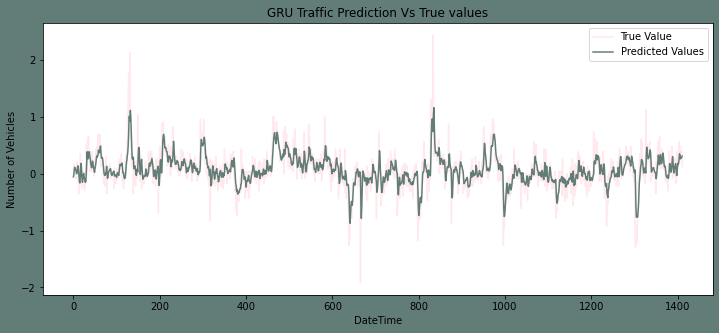

In [28]:
#Results for J1  
RMSE_J1=RMSE_Value(y_test_Junction1,PredJ1)  
PredictionsPlot(y_test_Junction1,PredJ1,0)  

In [32]:
#Predictions For Second Junction  
#PredJ2 = GRU_model(X_train_Junction2,y_test_Junction1,X_test_Junction2)  

ValueError: Data cardinality is ambiguous:
  x sizes: 13079
  y sizes: 1411
Make sure all arrays contain the same number of samples.

In [33]:
#Results for J2  
RMSE_J2=RMSE_Value(y_test_Junction2,PredJ2)  
PredictionsPlot(y_test_Junction2,PredJ2,1)  

NameError: name 'PredJ2' is not defined

In [34]:
#Predictions For Third Junction  
PredJ3 = GRU_model(X_train_Junction3,y_train_Junction3,X_test_Junction3)  

Epoch 1/50
88/88 [==============================] - 40s 335ms/step - loss: 0.2999
Epoch 2/50
88/88 [==============================] - 32s 362ms/step - loss: 0.2935
Epoch 3/50
88/88 [==============================] - 30s 346ms/step - loss: 0.2902
Epoch 4/50
88/88 [==============================] - 32s 360ms/step - loss: 0.2933
Epoch 5/50
88/88 [==============================] - 31s 354ms/step - loss: 0.2899
Epoch 6/50
88/88 [==============================] - 32s 359ms/step - loss: 0.2905
Epoch 7/50
88/88 [==============================] - 31s 347ms/step - loss: 0.2878
Epoch 8/50
88/88 [==============================] - 32s 367ms/step - loss: 0.2867
Epoch 9/50
88/88 [==============================] - 33s 370ms/step - loss: 0.2878
Epoch 10/50
88/88 [==============================] - 32s 364ms/step - loss: 0.2845
Epoch 11/50
88/88 [==============================] - 31s 357ms/step - loss: 0.2869
Epoch 12/50
88/88 [==============================] - 33s 378ms/step - loss: 0.2856
Epoch 13/50
8

Epoch 32/50
88/88 [==============================] - 32s 364ms/step - loss: 0.2720
Epoch 33/50
88/88 [==============================] - 32s 367ms/step - loss: 0.2692
Epoch 34/50
88/88 [==============================] - 36s 414ms/step - loss: 0.2800
Epoch 35/50
88/88 [==============================] - 32s 363ms/step - loss: 0.2743
Epoch 36/50
88/88 [==============================] - 31s 347ms/step - loss: 0.2708
Epoch 37/50
88/88 [==============================] - 33s 380ms/step - loss: 0.2691
Epoch 38/50
88/88 [==============================] - 34s 387ms/step - loss: 0.2722
Epoch 39/50
88/88 [==============================] - 32s 364ms/step - loss: 0.2682
Epoch 40/50
88/88 [==============================] - 33s 379ms/step - loss: 0.2681
Epoch 41/50
88/88 [==============================] - 33s 380ms/step - loss: 0.2661
Epoch 42/50
88/88 [==============================] - 35s 395ms/step - loss: 0.2686
Epoch 43/50
88/88 [==============================] - 33s 375ms/step - loss: 0.2660
Epoc

The root mean squared error is 0.6103648946883422.


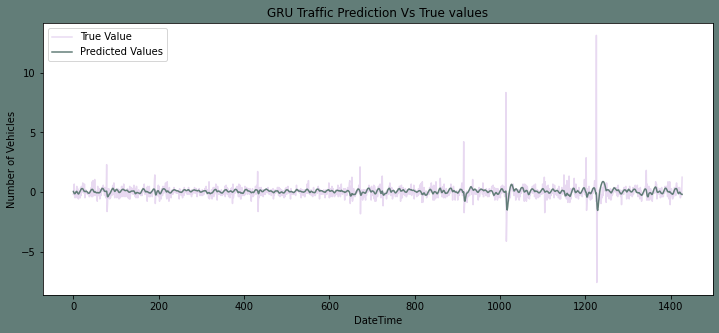

In [35]:
#Results for J3  
RMSE_J3=RMSE_Value(y_test_Junction3,PredJ3)  
PredictionsPlot(y_test_Junction3,PredJ3,2)  

In [ ]:
#Predictions For Forth Junction  
PredJ4 = GRU_model(X_train_Junction4,y_train_Junction4,x_test_Junction4)  

In [ ]:
#Results for J4  
RMSE_J4=RMSE_Value(y_test_Junction4,PredJ4)  
PredictionsPlot(y_test_Junction4,PredJ4,3)  

In [ ]:
# Set the data in lists to the initial error values of the four junctions.  
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]  
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]  
list_of_tuples = list(zip(Junctions, RMSE))  
# Creates pandas DataFrame.  
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])  
Results.style.background_gradient(cmap="Pastel1")    

In [ ]:
# Functions to inverse transforms and plot comparative plots  
# invert differenced forecast  
def inverse_difference(last_ob, value):  
    inversed = value + last_ob  
    return inversed  
  
#Plotting the comparison  
def Sub_Plots2(df_1, df_2,title,m):  
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")  
    fig.suptitle(title)  
     
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])  
    axes[0].set(ylabel ="Prediction")  
     
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")  
    axes[1].set(ylabel ="Orignal")  
    

In [ ]:
# The first junction's inverse transform
# invert the differenced forecast for Junction 1  
recover1 = dataframe_N1.Norm[-1412:-1].to_frame()  
recover1["Pred"]= PredJ1  
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()  
Transform_reverssed_J1.columns = ["Pred_Normed"]  
#Invert the normalization J1  
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + avg_J1  
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred  
#Plotting the Predictions with originals  
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], dataframe_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0) 

In [20]:
# The second junction's inverse transformation
#Invert the differenced J2  
recover2 = dataframe_N2.Norm[-1426:-1].to_frame() #len as per the diff  
recover2["Pred"]= PredJ2  
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()  
Transform_reverssed_J2.columns = ["Pred_Normed"]  
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + avg_J2  
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred  
#Plotting the Predictions with originals  
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], dataframe_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

NameError: name 'PredJ2' is not defined